In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
import dask.dataframe as dd

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier
from tqdm import tqdm
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
import spacy
import en_core_web_sm
from scipy.sparse import coo_matrix
from sklearn.metrics import log_loss
import xgboost as xgb
import seaborn as sn

In [2]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y) 
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    cmap=sn.light_palette("blue")
    plt.subplot(1, 3, 1)
    sn.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sn.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    sn.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [3]:
questions_data = pd.read_csv("df_fe_without_preprocessing_train.csv", encoding='latin-1')
questions_data = questions_data.fillna('')
nlp_features_data = pd.read_csv("nlp_features_train.csv", encoding='latin-1')
nlp_features_data = nlp_features_data.fillna('')

In [4]:
data_indexes = list(np.random.choice(questions_data.shape[0], int(100000), replace=False))
X_train, X_test, Y_train , Y_test = train_test_split(data_indexes, data_indexes , test_size=0.4)
print("X_train shape", len(X_train))
print("X_test shape", len(X_test))
print("="*40)
X_test, X_cv, Y_test, Y_cv = train_test_split(X_test, Y_test, test_size=0.5)
print("X_test shape", len(X_test))
print("X_cv shape", len(X_cv))
print("X_train shape", len(X_train))

X_train shape 60000
X_test shape 40000
X_test shape 20000
X_cv shape 20000
X_train shape 60000


In [5]:
train_questions_data = questions_data.iloc[X_train]
cv_questions_data = questions_data.iloc[X_cv]
test_questions_data = questions_data.iloc[X_test]
train_nlp_features_data = nlp_features_data.iloc[X_train]
cv_nlp_features_data = nlp_features_data.iloc[X_cv]
test_nlp_features_data = nlp_features_data.iloc[X_test]
print("train data size", train_questions_data.shape, train_nlp_features_data.shape)
print("cv data size", cv_questions_data.shape, cv_nlp_features_data.shape)
print("test data size", test_questions_data.shape, test_nlp_features_data.shape)

train data size (60000, 17) (60000, 21)
cv data size (20000, 17) (20000, 21)
test data size (20000, 17) (20000, 21)


In [6]:
questions1_train = train_questions_data['question1']
questions2_train = train_questions_data['question2']
questions_train = list(questions1_train) + list(questions2_train)
questions1_cv = cv_questions_data['question1']
questions2_cv = cv_questions_data['question2']
questions_cv = list(questions1_cv) + list(questions2_cv)
questions1_test = test_questions_data['question1']
questions2_test = test_questions_data['question2']
questions_test = list(questions1_test) + list(questions2_test)
print("train data size", len(questions_train), len(questions1_train), len(questions2_train) )
print("cv data size", len(questions_cv), len(questions1_cv), len(questions2_cv) )
print("test data size", len(questions_test), len(questions1_test), len(questions2_test))

train data size 120000 60000 60000
cv data size 40000 20000 20000
test data size 40000 20000 20000


In [7]:
tfidf = TfidfVectorizer(lowercase=False, min_df=10)
tfidf = tfidf.fit(questions_train)
questions1_train_vec = tfidf.transform(questions1_train)
questions2_train_vec = tfidf.transform(questions2_train)
questions1_cv_vec = tfidf.transform(questions1_cv)
questions2_cv_vec = tfidf.transform(questions2_cv)
questions1_test_vec = tfidf.transform(questions1_test)
questions2_test_vec = tfidf.transform(questions2_test)
print("train data size", questions1_train_vec.shape, questions2_train_vec.shape )
print("cv data size", questions1_cv_vec.shape, questions2_cv_vec.shape )
print("test data size", questions1_test_vec.shape, questions2_test_vec.shape)
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

train data size (60000, 7770) (60000, 7770)
cv data size (20000, 7770) (20000, 7770)
test data size (20000, 7770) (20000, 7770)


In [8]:
Y_train = train_questions_data["is_duplicate"]
Y_cv = cv_questions_data["is_duplicate"]
Y_test = test_questions_data["is_duplicate"]
train_questions_data = train_questions_data.drop(['qid1','qid2','question1','question2', 'is_duplicate'],axis=1)
train_nlp_features_data = train_nlp_features_data.drop(['qid1','qid2','question1','question2', 'is_duplicate'],axis=1)
cv_questions_data = cv_questions_data.drop(['qid1','qid2','question1','question2', 'is_duplicate'],axis=1)
cv_nlp_features_data = cv_nlp_features_data.drop(['qid1','qid2','question1','question2', 'is_duplicate'],axis=1)
test_questions_data = test_questions_data.drop(['qid1','qid2','question1','question2', 'is_duplicate'],axis=1)
test_nlp_features_data = test_nlp_features_data.drop(['qid1','qid2','question1','question2', 'is_duplicate'],axis=1)

questions1_train_vec = coo_matrix(questions1_train_vec)
questions2_train_vec = coo_matrix(questions2_train_vec)
questions_train_vec = pd.DataFrame(hstack([questions1_train_vec,questions2_train_vec]).toarray())

questions1_cv_vec = coo_matrix(questions1_cv_vec)
questions2_cv_vec = coo_matrix(questions2_cv_vec)
questions_cv_vec = pd.DataFrame(hstack([questions1_cv_vec,questions2_cv_vec]).toarray())

questions1_test_vec = coo_matrix(questions1_test_vec)
questions2_test_vec = coo_matrix(questions2_test_vec)
questions_test_vec = pd.DataFrame(hstack([questions1_test_vec, questions2_test_vec]).toarray())

In [9]:
Y_train.to_pickle('./Y_train_data.pkl')
Y_cv.to_pickle('./Y_cv_data.pkl')
Y_test.to_pickle('./Y_test_data.pkl')

In [12]:
questions_train_vec.index = train_questions_data.index
questions_train_vec['id']=train_questions_data['id']
train_questions_data = train_questions_data.merge(train_nlp_features_data, on='id',how='left')
result  = train_questions_data.merge(questions_train_vec, on='id',how='left')
result.to_csv('./tfidf_train_data.csv')

In [19]:
questions_cv_vec.index = cv_questions_data.index
questions_cv_vec['id']= cv_questions_data['id']
cv_questions_data = cv_questions_data.merge(cv_nlp_features_data, on='id',how='left')
result  = cv_questions_data.merge(questions_cv_vec, on='id',how='left')
result.to_csv('./tfidf_cv_data.csv')

In [20]:
questions_test_vec.index = test_questions_data.index
questions_test_vec['id']= test_questions_data['id']
test_questions_data = test_questions_data.merge(test_nlp_features_data, on='id',how='left')
result  = test_questions_data.merge(questions_test_vec, on='id',how='left')
result.to_csv('./tfidf_test_data.csv')

In [21]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = en_core_web_sm.load()
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
def tfidf_weighted_vector(list_of_sent):
    vecs = []
    i = 0
    for qu in tqdm(list(list_of_sent)):
        doc = nlp(qu) 
        # 384 is the number of dimensions of vectors 
        mean_vec = np.zeros([len(doc), len(doc[0].vector)])
        for word in doc:
            # word2vec
            vec = word.vector
            # fetch df score
            try:
                idf = word2tfidf[str(word)]
                print
            except:
                idf = 0
            # compute final vec
            mean_vec += vec * idf
        mean_vec = mean_vec.mean(axis=0)
        vecs.append(mean_vec)
        i = i +1
    return vecs

In [23]:
questions1_train_tfidfw2v_vec = tfidf_weighted_vector(questions1_train)
questions2_train_tfidfw2v_vec = tfidf_weighted_vector(questions2_train)
questions1_cv_tfidfw2v_vec = tfidf_weighted_vector(questions1_cv)
questions2_cv_tfidfw2v_vec = tfidf_weighted_vector(questions2_cv)
questions1_test_tfidfw2v_vec = tfidf_weighted_vector(questions1_test)
questions2_test_tfidfw2v_vec = tfidf_weighted_vector(questions2_test)

100%|██████████| 20000/20000 [03:00<00:00, 111.07it/s]


In [24]:
questions_train_tfidfw2v_vec = pd.DataFrame(np.hstack((questions1_train_tfidfw2v_vec, questions2_train_tfidfw2v_vec)))
questions_cv_tfidfw2v_vec = pd.DataFrame(np.hstack((questions1_cv_tfidfw2v_vec, questions2_cv_tfidfw2v_vec)))
questions_test_tfidfw2v_vec = pd.DataFrame(np.hstack((questions1_test_tfidfw2v_vec, questions2_test_tfidfw2v_vec)))

In [25]:
questions_train_tfidfw2v_vec['id']=train_questions_data['id']
train_questions_data = train_questions_data.merge(train_nlp_features_data, on='id',how='left')
result  = train_questions_data.merge(questions_train_tfidfw2v_vec, on='id',how='left')
result.to_csv('./train_tfidfw2v_data.csv')

In [26]:
questions_cv_tfidfw2v_vec['id']=cv_questions_data['id']
cv_questions_data = cv_questions_data.merge(cv_nlp_features_data, on='id',how='left')
result  = cv_questions_data.merge(questions_cv_tfidfw2v_vec, on='id',how='left')
result.to_csv('./cv_tfidfw2v_data.csv')

In [27]:
questions_test_tfidfw2v_vec['id']=test_questions_data['id']
test_questions_data = test_questions_data.merge(test_nlp_features_data, on='id',how='left')
result  = test_questions_data.merge(questions_test_tfidfw2v_vec, on='id',how='left')
result.to_csv('./test_tfidfw2v_data.csv')

<h3>Hyperparameter tuning of XGBoost

In [3]:
X_train_vec = pd.read_csv('./train_tfidfw2v_data.csv')
X_test_vec = pd.read_csv('./test_tfidfw2v_data.csv')
X_cv_vec = pd.read_csv('./cv_tfidfw2v_data.csv')
Y_train = pd.read_pickle('./Y_train_data.pkl')
Y_cv = pd.read_pickle('./Y_cv_data.pkl')
Y_test = pd.read_pickle('./Y_test_data.pkl')

In [4]:
print(X_train_vec.shape)
print(X_test_vec.shape)
print(X_cv_vec.shape)
print(Y_train.shape)
print(Y_cv.shape)
print(Y_test.shape)

(60000, 235)
(20000, 235)
(20000, 235)
(60000,)
(20000,)
(20000,)


In [41]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train_vec, label=Y_train)
d_test = xgb.DMatrix(X_test_vec, label=Y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train_vec,Y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(Y_test, predict_y, labels=np.array([0,1]), eps=1e-15))

[0]	train-logloss:0.684668	valid-logloss:0.684808
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.615106	valid-logloss:0.615051
[20]	train-logloss:0.564008	valid-logloss:0.564207
[30]	train-logloss:0.526032	valid-logloss:0.526346
[40]	train-logloss:0.496981	valid-logloss:0.49748
[50]	train-logloss:0.47427	valid-logloss:0.474826
[60]	train-logloss:0.456405	valid-logloss:0.457052
[70]	train-logloss:0.442027	valid-logloss:0.442853
[80]	train-logloss:0.43018	valid-logloss:0.431226
[90]	train-logloss:0.420685	valid-logloss:0.421748
[100]	train-logloss:0.412704	valid-logloss:0.413887
[110]	train-logloss:0.406092	valid-logloss:0.407352
[120]	train-logloss:0.40042	valid-logloss:0.401818
[130]	train-logloss:0.39562	valid-logloss:0.397077
[140]	train-logloss:0.391648	valid-logloss:0.393191
[150]	train-logloss:0.387998	valid-logloss:0.389608
[160]	train-logloss:0.384813	vali

In [6]:
n_estimators =[100,250,500]
eta   = [0.1,1] 
max_depth = [2,3,4] 

In [7]:
hyper_parameters_list = []
for d in max_depth:
    for e in eta:
        for n in n_estimators:
            hyper_parameters_list.append((d,n,e))

In [8]:
# hyperparameter tuning for max_depth and min_child_weight
min_logloss = float("Inf")
best_params = None

d_train = xgb.DMatrix(X_train_vec, label=Y_train)
d_test = xgb.DMatrix(X_test_vec, label=Y_test)
for d, n, e in hyper_parameters_list:
    print("Executing depth, n_estimators, eta:",d,n,e)
    params = {}
    params['max_depth'] = d
    params['n_estimators'] = n
    params['eta'] = e
    params['objective'] = 'binary:logistic'
    params['eval_metric'] = 'logloss'
    
    cv_logloss = xgb.cv(params, d_train, 400, early_stopping_rounds=20)
    
    logloss = cv_logloss['test-logloss-mean'].min()
    print("Logloss computed:", logloss)

Executing depth, n_estimators, eta: 2 100 0.1
Logloss computed: 0.35625166666666663
Executing depth, n_estimators, eta: 2 250 0.1
Logloss computed: 0.35625166666666663
Executing depth, n_estimators, eta: 2 500 0.1
Logloss computed: 0.35625166666666663
Executing depth, n_estimators, eta: 2 100 1
Logloss computed: 0.37064366666666665
Executing depth, n_estimators, eta: 2 250 1
Logloss computed: 0.37064366666666665
Executing depth, n_estimators, eta: 2 500 1
Logloss computed: 0.37064366666666665
Executing depth, n_estimators, eta: 3 100 0.1
Logloss computed: 0.347696
Executing depth, n_estimators, eta: 3 250 0.1
Logloss computed: 0.347696
Executing depth, n_estimators, eta: 3 500 0.1
Logloss computed: 0.347696
Executing depth, n_estimators, eta: 3 100 1
Logloss computed: 0.37626199999999993
Executing depth, n_estimators, eta: 3 250 1
Logloss computed: 0.37626199999999993
Executing depth, n_estimators, eta: 3 500 1
Logloss computed: 0.37626199999999993
Executing depth, n_estimators, eta: 4

In [ ]:
Final Observation:
    Log loss is minimum at depth=4 n_estimators = 100 , eta =0.1, hence choosing it as a best hyperparameter

In [12]:
# Hyperparameter tuned model with best hyperparameters found using CV and reduced test log-loss.

import xgboost as xgb
params= {}

params['n_estimators'] = 100
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.1
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train_vec, label=Y_train)
d_test = xgb.DMatrix(X_test_vec, label=Y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)


xgdmat = xgb.DMatrix(X_train_vec,Y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(Y_test, predict_y, labels=np.array([0,1]), eps=1e-15))

[0]	train-logloss:0.652902	valid-logloss:0.652785
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.464346	valid-logloss:0.464842
[20]	train-logloss:0.409191	valid-logloss:0.409918
[30]	train-logloss:0.386361	valid-logloss:0.387762
[40]	train-logloss:0.373965	valid-logloss:0.376364
[50]	train-logloss:0.365935	valid-logloss:0.369341
[60]	train-logloss:0.358208	valid-logloss:0.363318
[70]	train-logloss:0.35262	valid-logloss:0.359326
[80]	train-logloss:0.347869	valid-logloss:0.356143
[90]	train-logloss:0.343157	valid-logloss:0.353121
[100]	train-logloss:0.339429	valid-logloss:0.350956
[110]	train-logloss:0.336204	valid-logloss:0.34948
[120]	train-logloss:0.332569	valid-logloss:0.347714
[130]	train-logloss:0.329963	valid-logloss:0.346555
[140]	train-logloss:0.327545	valid-logloss:0.34543
[150]	train-logloss:0.325146	valid-logloss:0.344833
[160]	train-logloss:0.322503	va

In [22]:
ypred_test  = predict_y > 0.5  
ypred_test = ypred_test.astype(int)  
predict_train = bst.predict(d_train)
ypred_train  = predict_train > 0.5  
ypred_train = ypred_train.astype(int)  
test_log_loss = log_loss(Y_test, predict_y,labels=np.array([0,1]), eps=1e-15)
train_log_loss = log_loss(Y_train, predict_train, labels=np.array([0,1]), eps=1e-15)

The log loss of the test data is 0.27415895648786953
The log loss of the train data is 0.3368123794829563
The confusion matrix, Recall and precision matrix for train data:
The confusion matrix, Recall and precision matrix for test data:


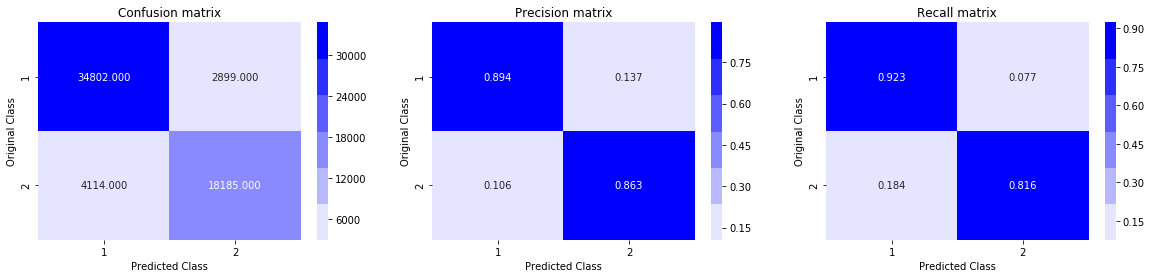

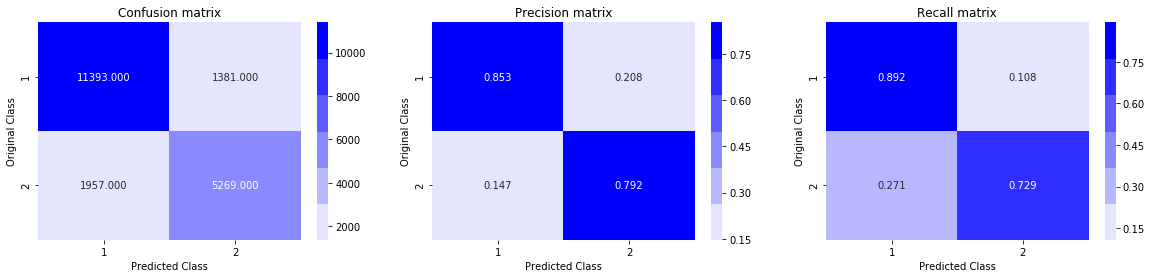

In [24]:
#Test Data AUC Value and Confusion matrix for test data and train data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
print("The log loss of the test data is", train_log_loss)
print("The log loss of the train data is", test_log_loss)
print("The confusion matrix, Recall and precision matrix for train data:")
print("The confusion matrix, Recall and precision matrix for test data:")
plot_confusion_matrix(Y_train, ypred_train)
plot_confusion_matrix(Y_test, ypred_test)

<h3>Logistic Regression using TF-IDF text vectors</h3>

In [3]:
X_train_vec = pd.read_csv('./tfidf_train_data.csv')
X_test_vec = pd.read_csv('./tfidf_test_data.csv')
X_cv_vec = pd.read_csv('./tfidf_cv_data.csv')
Y_train = pd.read_pickle('./Y_train_data.pkl')
Y_cv = pd.read_pickle('./Y_cv_data.pkl')
Y_test = pd.read_pickle('./Y_test_data.pkl')

In [6]:
from sklearn.preprocessing import StandardScaler
standardscalar = StandardScaler(with_mean=False).fit(X_train_vec)
X_train_vec = standardscalar.transform(X_train_vec)
X_cv_vec = standardscalar.transform(X_cv_vec)
X_test_vec = standardscalar.transform(X_test_vec)
print(X_train_vec.shape)
print(X_test_vec.shape)
print(X_cv_vec.shape)
print(Y_train.shape)
print(Y_cv.shape)
print(Y_test.shape)

/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


(60000, 15568)
(20000, 15568)
(20000, 15568)
(60000,)
(20000,)
(20000,)


In [7]:
alpha = [10**-5, 10**-4, 10**-3,10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4, 10**5]

In [22]:
#Cross Validation to find the best alpha value
#Iteratively training the Linear SVM model for best alpha value 
x_axis = []
y_axis_train = []
y_axis_cv = []
for a in alpha:
    print("Executing c:", a)
    model = SGDClassifier(loss='log', alpha=a , class_weight='balanced', verbose=3)
    calib_model = CalibratedClassifierCV(model, method="sigmoid")
    calib_model.fit(X_train_vec, Y_train)
    y_pred = calib_model.predict_proba(X_train_vec)
    train_log_loss = log_loss(Y_train, y_pred)
    print("The train log loss:", train_log_loss)
    y_axis_train.append(train_log_loss)
    y_pred = calib_model.predict_proba(X_cv_vec)
    cv_log_loss = log_loss(Y_cv, y_pred)
    print("The CV log loss:", cv_log_loss)
    y_axis_cv.append(cv_log_loss)
    print("Executing", a, "Train log loss", train_log_loss , "CV log loss", cv_log_loss)

Executing c: 1e-05
-- Epoch 1
Norm: 20416.67, NNZs: 13746, Bias: -2160.708115, T: 40000, Avg. loss: 7165.144565
Total training time: 0.87 seconds.
-- Epoch 2
Norm: 12738.86, NNZs: 14518, Bias: -2421.606781, T: 80000, Avg. loss: 2168.609023
Total training time: 1.70 seconds.
-- Epoch 3
Norm: 9648.12, NNZs: 14748, Bias: -2529.536963, T: 120000, Avg. loss: 1127.500083
Total training time: 2.51 seconds.
-- Epoch 4
Norm: 7901.99, NNZs: 14859, Bias: -2585.705557, T: 160000, Avg. loss: 728.335400
Total training time: 3.32 seconds.
-- Epoch 5
Norm: 6761.76, NNZs: 14924, Bias: -2624.966925, T: 200000, Avg. loss: 531.207488
Total training time: 4.13 seconds.
-- Epoch 1
Norm: 20121.55, NNZs: 13737, Bias: -2487.606332, T: 40000, Avg. loss: 7126.855276
Total training time: 0.88 seconds.
-- Epoch 2
Norm: 12699.79, NNZs: 14535, Bias: -2744.819601, T: 80000, Avg. loss: 2161.210575
Total training time: 1.71 seconds.
-- Epoch 3
Norm: 9630.95, NNZs: 14748, Bias: -2845.701500, T: 120000, Avg. loss: 1108.0

Norm: 1.48, NNZs: 15549, Bias: -1.139936, T: 80000, Avg. loss: 0.421033
Total training time: 2.81 seconds.
-- Epoch 3
Norm: 1.32, NNZs: 15549, Bias: -1.160369, T: 120000, Avg. loss: 0.364657
Total training time: 4.35 seconds.
-- Epoch 4
Norm: 1.26, NNZs: 15549, Bias: -1.173997, T: 160000, Avg. loss: 0.350035
Total training time: 5.72 seconds.
-- Epoch 5
Norm: 1.23, NNZs: 15549, Bias: -1.184372, T: 200000, Avg. loss: 0.342811
Total training time: 7.17 seconds.
-- Epoch 1
Norm: 2.14, NNZs: 15541, Bias: -1.434470, T: 40000, Avg. loss: 1.448245
Total training time: 1.47 seconds.
-- Epoch 2
Norm: 1.47, NNZs: 15541, Bias: -1.466622, T: 80000, Avg. loss: 0.419417
Total training time: 2.85 seconds.
-- Epoch 3
Norm: 1.31, NNZs: 15541, Bias: -1.483484, T: 120000, Avg. loss: 0.361180
Total training time: 4.30 seconds.
-- Epoch 4
Norm: 1.25, NNZs: 15541, Bias: -1.497073, T: 160000, Avg. loss: 0.346322
Total training time: 5.73 seconds.
-- Epoch 5
Norm: 1.22, NNZs: 15541, Bias: -1.507360, T: 200000

-- Epoch 1
Norm: 0.00, NNZs: 15541, Bias: -0.068810, T: 40000, Avg. loss: 0.685260
Total training time: 1.38 seconds.
-- Epoch 2
Norm: 0.00, NNZs: 15541, Bias: -0.068800, T: 80000, Avg. loss: 0.684659
Total training time: 2.87 seconds.
-- Epoch 3
Norm: 0.00, NNZs: 15541, Bias: -0.068794, T: 120000, Avg. loss: 0.684656
Total training time: 4.31 seconds.
-- Epoch 4
Norm: 0.00, NNZs: 15541, Bias: -0.068789, T: 160000, Avg. loss: 0.684645
Total training time: 5.77 seconds.
-- Epoch 5
Norm: 0.00, NNZs: 15541, Bias: -0.068786, T: 200000, Avg. loss: 0.684643
Total training time: 7.22 seconds.
-- Epoch 1
Norm: 0.00, NNZs: 15538, Bias: -0.070322, T: 40000, Avg. loss: 0.684556
Total training time: 1.42 seconds.
-- Epoch 2
Norm: 0.00, NNZs: 15538, Bias: -0.070311, T: 80000, Avg. loss: 0.684508
Total training time: 2.84 seconds.
-- Epoch 3
Norm: 0.00, NNZs: 15538, Bias: -0.070304, T: 120000, Avg. loss: 0.684489
Total training time: 4.31 seconds.
-- Epoch 4
Norm: 0.00, NNZs: 15538, Bias: -0.070300,

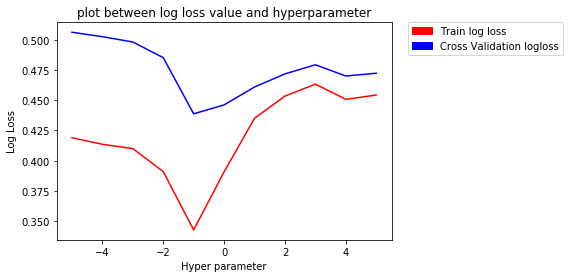

In [24]:
#Plot between AUC and hyperparameter for Validation data and training data
x_axis_log = []
for each in alpha:
    x_axis_log.append(round(log(each, 10)))
plt.plot(x_axis_log, y_axis_train, color='red')
plt.plot(x_axis_log, y_axis_cv, color='blue')
plt.title('plot between log loss value and hyperparameter')
blue_patch = mpatches.Patch(color='blue', label='Cross Validation logloss')
red_patch = mpatches.Patch(color='red', label='Train log loss')
plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hyper parameter')
plt.ylabel('Log Loss')
plt.show()

In [ ]:
Final Observation:
    At alpha = 0.1, both train and test log loss is minimum.Hence choosing it as best hyperparameter

In [27]:
#Training the Linear SVM with the best hyperparameter
model = SGDClassifier(loss='log', alpha=0.1 , class_weight='balanced', verbose=3)
calib_model = CalibratedClassifierCV(model, method="sigmoid")
calib_model.fit(X_train_vec, Y_train)

y_scores = calib_model.predict_proba(X_train_vec)
y_pred_train = calib_model.predict(X_train_vec)
train_log_loss = log_loss(Y_train, y_scores)
y_scores = calib_model.predict_proba(X_test_vec)
test_log_loss = log_loss(Y_test, y_scores)
y_pred_test = calib_model.predict(X_test_vec)

-- Epoch 1
Norm: 2.15, NNZs: 15549, Bias: -1.289551, T: 40000, Avg. loss: 1.434335
Total training time: 1.40 seconds.
-- Epoch 2
Norm: 1.47, NNZs: 15549, Bias: -1.319953, T: 80000, Avg. loss: 0.420030
Total training time: 2.83 seconds.
-- Epoch 3
Norm: 1.32, NNZs: 15549, Bias: -1.338114, T: 120000, Avg. loss: 0.363850
Total training time: 4.28 seconds.
-- Epoch 4
Norm: 1.25, NNZs: 15549, Bias: -1.350100, T: 160000, Avg. loss: 0.348640
Total training time: 5.72 seconds.
-- Epoch 5
Norm: 1.22, NNZs: 15549, Bias: -1.360393, T: 200000, Avg. loss: 0.342186
Total training time: 7.19 seconds.
-- Epoch 1
Norm: 2.14, NNZs: 15541, Bias: -1.715922, T: 40000, Avg. loss: 1.430556
Total training time: 1.46 seconds.
-- Epoch 2
Norm: 1.47, NNZs: 15541, Bias: -1.744324, T: 80000, Avg. loss: 0.416091
Total training time: 2.99 seconds.
-- Epoch 3
Norm: 1.31, NNZs: 15541, Bias: -1.759800, T: 120000, Avg. loss: 0.360138
Total training time: 4.42 seconds.
-- Epoch 4
Norm: 1.25, NNZs: 15541, Bias: -1.771167,

The log loss of the test data is 0.3423735209538949
The log loss of the train data is 0.4474567348588955
The confusion matrix, Recall and precision matrix for train data:
The confusion matrix, Recall and precision matrix for test data:


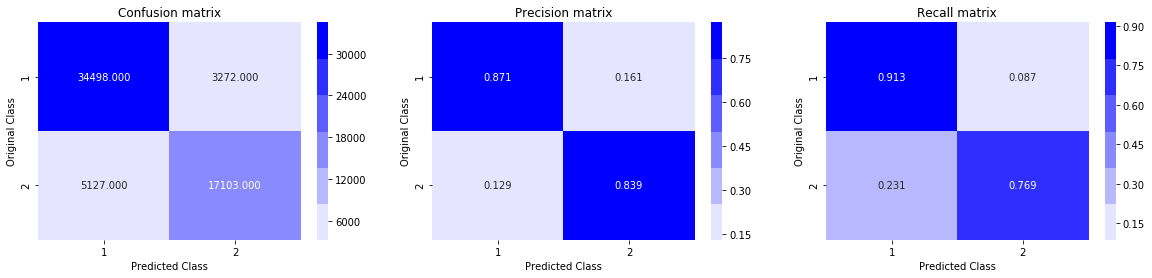

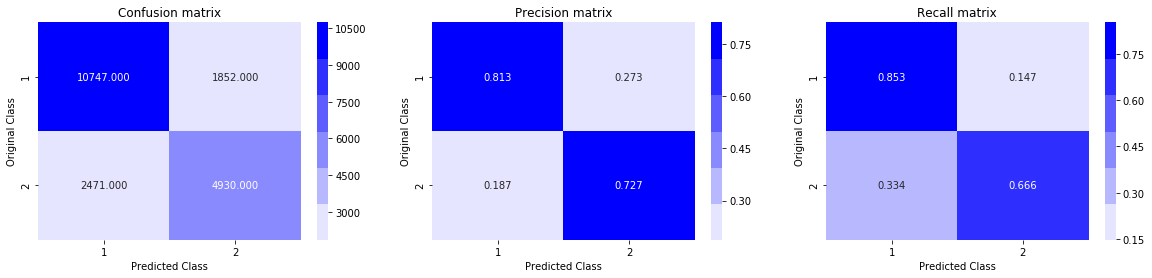

In [28]:
#Test Data AUC Value and Confusion matrix for test data and train data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
print("The log loss of the test data is", train_log_loss)
print("The log loss of the train data is", test_log_loss)
print("The confusion matrix, Recall and precision matrix for train data:")
print("The confusion matrix, Recall and precision matrix for test data:")
plot_confusion_matrix(Y_train, y_pred_train)
plot_confusion_matrix(Y_test, y_pred_test)

<h3> Linear SVM using TF_IDF Text data </h3>

In [12]:
#Cross Validation to find the best alpha value
#Iteratively training the Linear SVM model for best alpha value 
x_axis = []
y_axis_train = []
y_axis_cv = []
for a in alpha:
    print("Executing c:", a)
    model = SGDClassifier(loss='hinge', alpha=a , class_weight='balanced', verbose=3)
    calib_model = CalibratedClassifierCV(model, method="sigmoid")
    calib_model.fit(X_train_vec, Y_train)
    y_pred = calib_model.predict_proba(X_train_vec)
    train_log_loss = log_loss(Y_train, y_pred)
    print("The train log loss:", train_log_loss)
    y_axis_train.append(train_log_loss)
    y_pred = calib_model.predict_proba(X_cv_vec)
    cv_log_loss = log_loss(Y_cv, y_pred)
    print("The CV log loss:", cv_log_loss)
    y_axis_cv.append(cv_log_loss)
    print("Executing", a, "Train log loss", train_log_loss , "CV log loss", cv_log_loss)

Executing c: 1e-05
-- Epoch 1
Norm: 20301.20, NNZs: 13745, Bias: -2254.086125, T: 40000, Avg. loss: 7243.373296
Total training time: 0.80 seconds.
-- Epoch 2
Norm: 12787.08, NNZs: 14511, Bias: -2483.575572, T: 80000, Avg. loss: 2163.125252
Total training time: 1.56 seconds.
-- Epoch 3
Norm: 9682.95, NNZs: 14729, Bias: -2602.107075, T: 120000, Avg. loss: 1126.073595
Total training time: 2.36 seconds.
-- Epoch 4
Norm: 7927.62, NNZs: 14822, Bias: -2649.441996, T: 160000, Avg. loss: 745.357886
Total training time: 3.12 seconds.
-- Epoch 5
Norm: 6787.42, NNZs: 14896, Bias: -2683.147870, T: 200000, Avg. loss: 542.525858
Total training time: 3.84 seconds.
-- Epoch 1
Norm: 20313.07, NNZs: 13732, Bias: -2422.671755, T: 40000, Avg. loss: 7286.425509
Total training time: 0.84 seconds.
-- Epoch 2
Norm: 12673.07, NNZs: 14468, Bias: -2693.358275, T: 80000, Avg. loss: 2142.015591
Total training time: 1.65 seconds.
-- Epoch 3
Norm: 9610.59, NNZs: 14690, Bias: -2788.030232, T: 120000, Avg. loss: 1108.1

Norm: 1.85, NNZs: 14874, Bias: -2.123768, T: 80000, Avg. loss: 0.569248
Total training time: 1.86 seconds.
-- Epoch 3
Norm: 1.58, NNZs: 15031, Bias: -2.132061, T: 120000, Avg. loss: 0.437880
Total training time: 2.74 seconds.
-- Epoch 4
Norm: 1.45, NNZs: 15097, Bias: -2.140700, T: 160000, Avg. loss: 0.388243
Total training time: 3.66 seconds.
-- Epoch 5
Norm: 1.39, NNZs: 15147, Bias: -2.145529, T: 200000, Avg. loss: 0.358237
Total training time: 4.52 seconds.
-- Epoch 1
Norm: 2.73, NNZs: 14207, Bias: -0.364903, T: 40000, Avg. loss: 1.864099
Total training time: 0.95 seconds.
-- Epoch 2
Norm: 1.87, NNZs: 14917, Bias: -0.424101, T: 80000, Avg. loss: 0.578125
Total training time: 1.80 seconds.
-- Epoch 3
Norm: 1.61, NNZs: 15048, Bias: -0.454698, T: 120000, Avg. loss: 0.443502
Total training time: 2.68 seconds.
-- Epoch 4
Norm: 1.48, NNZs: 15116, Bias: -0.479653, T: 160000, Avg. loss: 0.390676
Total training time: 3.57 seconds.
-- Epoch 5
Norm: 1.41, NNZs: 15152, Bias: -0.495420, T: 200000

-- Epoch 1
Norm: 0.00, NNZs: 15541, Bias: -0.141642, T: 40000, Avg. loss: 0.962467
Total training time: 1.25 seconds.
-- Epoch 2
Norm: 0.00, NNZs: 15541, Bias: -0.141642, T: 80000, Avg. loss: 0.962279
Total training time: 2.49 seconds.
-- Epoch 3
Norm: 0.00, NNZs: 15541, Bias: -0.141641, T: 120000, Avg. loss: 0.962238
Total training time: 3.75 seconds.
-- Epoch 4
Norm: 0.00, NNZs: 15541, Bias: -0.141641, T: 160000, Avg. loss: 0.962206
Total training time: 5.06 seconds.
-- Epoch 5
Norm: 0.00, NNZs: 15541, Bias: -0.141641, T: 200000, Avg. loss: 0.962219
Total training time: 6.34 seconds.
-- Epoch 1
Norm: 0.00, NNZs: 15538, Bias: -0.140455, T: 40000, Avg. loss: 0.962647
Total training time: 1.30 seconds.
-- Epoch 2
Norm: 0.00, NNZs: 15538, Bias: -0.140456, T: 80000, Avg. loss: 0.962580
Total training time: 2.60 seconds.
-- Epoch 3
Norm: 0.00, NNZs: 15538, Bias: -0.140455, T: 120000, Avg. loss: 0.962591
Total training time: 3.93 seconds.
-- Epoch 4
Norm: 0.00, NNZs: 15538, Bias: -0.140455,

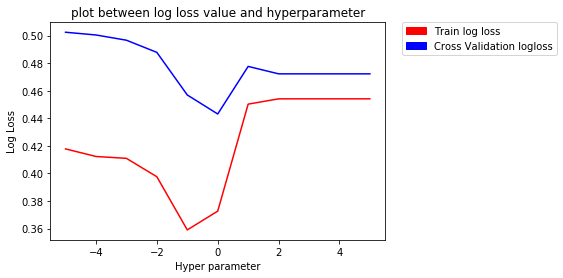

In [16]:
#Plot between AUC and hyperparameter for Validation data and training data
from math import log
import matplotlib.patches as mpatches
x_axis_log = []
for each in alpha:
    x_axis_log.append(round(log(each, 10)))
plt.plot(x_axis_log, y_axis_train, color='red')
plt.plot(x_axis_log, y_axis_cv, color='blue')
plt.title('plot between log loss value and hyperparameter')
blue_patch = mpatches.Patch(color='blue', label='Cross Validation logloss')
red_patch = mpatches.Patch(color='red', label='Train log loss')
plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hyper parameter')
plt.ylabel('Log Loss')
plt.show()

In [ ]:
Final Observation:
    At alpha = 1, both train and test log loss is minimum.Hence choosing it as best hyperparameter

In [20]:
#Training the Linear SVM with the best hyperparameter
model = SGDClassifier(loss='hinge', alpha=1 , class_weight='balanced',verbose=3)
calib_model = CalibratedClassifierCV(model, method="sigmoid")
calib_model.fit(X_train_vec, Y_train)

y_scores = calib_model.predict_proba(X_train_vec)
y_pred_train = calib_model.predict(X_train_vec)
train_log_loss = log_loss(Y_train, y_scores)
y_scores = calib_model.predict_proba(X_test_vec)
y_pred_test = calib_model.predict(X_test_vec)
test_log_loss = log_loss(Y_test,y_scores)

-- Epoch 1
Norm: 0.54, NNZs: 15187, Bias: -0.885293, T: 40000, Avg. loss: 0.665408
Total training time: 1.07 seconds.
-- Epoch 2
Norm: 0.50, NNZs: 15365, Bias: -0.894348, T: 80000, Avg. loss: 0.487762
Total training time: 2.14 seconds.
-- Epoch 3
Norm: 0.49, NNZs: 15391, Bias: -0.900078, T: 120000, Avg. loss: 0.467026
Total training time: 3.22 seconds.
-- Epoch 4
Norm: 0.48, NNZs: 15406, Bias: -0.903213, T: 160000, Avg. loss: 0.453683
Total training time: 4.30 seconds.
-- Epoch 5
Norm: 0.48, NNZs: 15412, Bias: -0.906295, T: 200000, Avg. loss: 0.449206
Total training time: 5.51 seconds.
-- Epoch 1
Norm: 0.57, NNZs: 15234, Bias: 0.540838, T: 40000, Avg. loss: 0.708053
Total training time: 1.10 seconds.
-- Epoch 2
Norm: 0.53, NNZs: 15382, Bias: 0.514792, T: 80000, Avg. loss: 0.516651
Total training time: 2.20 seconds.
-- Epoch 3
Norm: 0.52, NNZs: 15407, Bias: 0.499410, T: 120000, Avg. loss: 0.493124
Total training time: 3.31 seconds.
-- Epoch 4
Norm: 0.51, NNZs: 15412, Bias: 0.488258, T: 

The log loss of the test data is 0.37214094212319093
The log loss of the train data is 0.45048583414678417
The confusion matrix, Recall and precision matrix for train data:
The confusion matrix, Recall and precision matrix for test data:


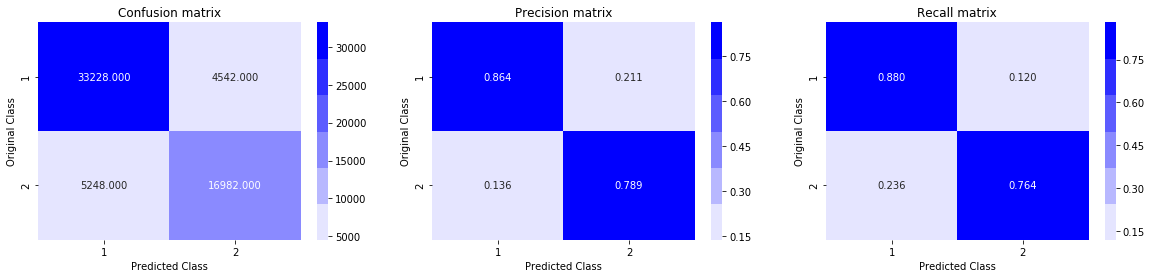

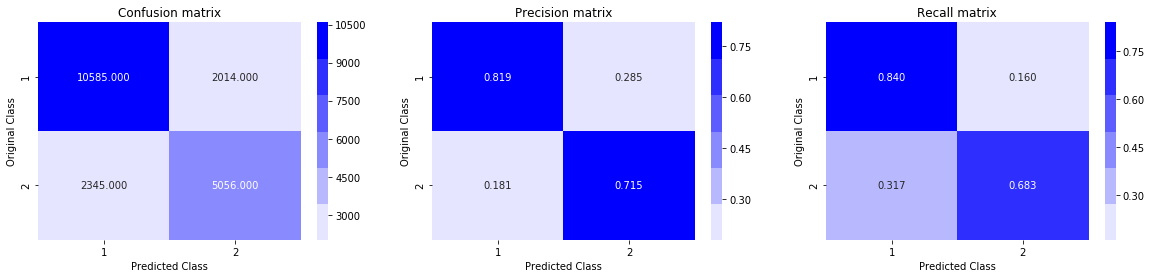

In [21]:
#Test Data AUC Value and Confusion matrix for test data and train data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
print("The log loss of the test data is", train_log_loss)
print("The log loss of the train data is", test_log_loss)
print("The confusion matrix, Recall and precision matrix for train data:")
print("The confusion matrix, Recall and precision matrix for test data:")
plot_confusion_matrix(Y_train, y_pred_train)
plot_confusion_matrix(Y_test, y_pred_test)

In [ ]:
#conclusion

In [31]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Type", "Hyper Parameter", "Test Log loss", "Recall - class 1 & 2", "Precision - class 1 & 2"]
x.add_row(["XGBoost - TFIDF W2v","eta = 0.1 \n max_depth = 4 \n n_estimators = 100", 0.274158956 ,[0.892, 0.729] ,[0.853, 0.792] ] )
x.add_row(["Logistic Regression - TFIDF Vec", "alpha=0.1" , 0.342373520 , [0.853, 0.666], [ 0.813, 0.727] ] )
x.add_row(["TF-IDF model-- TFIDF Vec", "alpha=1" , 0.37214094212 ,[0.840, 0.683] ,[0.819, 0.715] ] )
print(x)

+---------------------------------+---------------------+---------------+----------------------+-------------------------+
|               Type              |   Hyper Parameter   | Test Log loss | Recall - class 1 & 2 | Precision - class 1 & 2 |
+---------------------------------+---------------------+---------------+----------------------+-------------------------+
|       XGBoost - TFIDF W2v       |      eta = 0.1      |  0.274158956  |    [0.892, 0.729]    |      [0.853, 0.792]     |
|                                 |    max_depth = 4    |               |                      |                         |
|                                 |  n_estimators = 100 |               |                      |                         |
| Logistic Regression - TFIDF Vec |      alpha=0.1      |   0.34237352  |    [0.853, 0.666]    |      [0.813, 0.727]     |
|     TF-IDF model-- TFIDF Vec    |       alpha=1       | 0.37214094212 |    [0.84, 0.683]     |      [0.819, 0.715]     |
+---------------

<h6>Observations:</h6>
    
<p>
1)First of all inorder to remove the data leakage problem which was prevelant in the existing data, I randomly sampled
100k data points and splitted it into train,test and cv in the ration 60%, 20% and 20%
</p>
<p>
2)Then I applied seperately tf-idf vectorization and tf-idf avg w2v vectorization, and stored those data in seperate
csv files to avoid processing
</p>
<p>
3)On doing hyperparameter tuning on xgboost, one can find that the log loss minimizes to 0.34 at eta = 0.1,
max_depth = 4,n_estimators = 100.On test data log loss reduces furthur to about 0.27.The recall and precision 
values though there is a little difference that we have suceeded in reducing the bias to a very good extend
</p>
<p>
4)When logistic regression is applied on tf-idf weighted w2v, we obtained train and test log loss of
0.51 and 0.52 respectively.But on tf-idf based vectors we could reduce the test log loss furthur to 0.34.But the recall
values of class 1 and 2 may indicate some bias in the model as there is a significant difference in both the recall
values
</p>
<p>
5)Same goes for linear SVM, on tf-idf weighted w2v we got test log loss of 0.44 which reduced furthur to 0.37.
And also there is some significant difference in recall values of class 1 and 2 may indicate a light bias issue 
in the model
</p>